# About RBMs

Let us assume we have $d$ visible units and $n$ hidden units.


Energy of an RBM

$$
E(\pmb{x},\pmb{h}) = - \pmb{c}^T \pmb{v} - \pmb{b}^T \pmb{h} - \pmb{h}^T \pmb{W} \pmb{v}
$$

Probability of an assignment of hidden and visible units:

$$
P(v,h) = - \frac{ e^{-E(v,h)} } { \sum_{( \bar{v},\bar{h}) \in \{0,1\}^d x \{0,1\}^n } e^{-E(\bar{v},\bar{h})} }
$$

In [1]:
import sys
import os
import inspect
#sys.path.insert(0,'..')

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent =  os.path.dirname(currentdir) + '/RBM'
sys.path.insert(0,parent)

%load_ext autoreload
%autoreload 2
%matplotlib inline

from timeit import default_timer as timer
import numpy as np
import time
import matplotlib.pyplot as plt
import numexpr  as ne
import profile
import rbm as Rbm
import pandas

## Read the MNIST 

In [6]:
X_ = pandas.read_csv("../Datasets/MNIST/train_mnist.csv")
Y = X_["label"].values
X = X_[X_.columns[1:]].values

del(X_)

print('\t files read')
X = np.array(X, dtype ='float32')

X = np.array(([14,14,14,14,14],[0,0,0,0,0]))
Y = np.array(([1,0]))
Xaux = np.array(X, dtype='float32')

saved_models_folder = "saved_models"
visible_dim = X.shape[1]
hidden_dim = 225
epochs = 100
K = 1
lr = 0.1
batch_size = 10

print(X)
print(Y)
print(Xaux)

	 files read
[[14 14 14 14 14]
 [ 0  0  0  0  0]]
[1 0]
[[14. 14. 14. 14. 14.]
 [ 0.  0.  0.  0.  0.]]


## Defining an RBM


In [7]:
rbm_ = Rbm.RBM(visible_dim=visible_dim,
               hidden_dim=hidden_dim,
               seed=42,
               mu=0, 
               sigma=0.3,
               monitor_time=True)

In [8]:
rbm_.W.shape, rbm_.b.shape, rbm_

((5, 225), (5,), <rbm.RBM at 0x1cedb6c0d68>)

## Benchmarking `.fit` method (vectorized vs non vectorized)

In [9]:
Xaux = np.array(Xaux, dtype="float64")

In [10]:
%%time
rbm_.fit(Xaux, 
         method='CDK',
         K=K,
         lr=lr,
         epochs=1,
         batch_size=128,
         plot_weights=False)

	Last epoch: 0 	time per epoch: 0.48	total time: 0.48
	Training finished


Wall time: 485 ms


In [11]:
%%time
rbm_.fit(Xaux, 
         method='vectorized_CDK',
         K=K,
         lr=0.01,
         epochs=1,
         batch_size=128,
         plot_weights=False)

	Last epoch: 0 	time per epoch: 0.18	total time: 0.18
	Training finished


Wall time: 181 ms


## Training multiple epochs and showing the weights

In [12]:
rbm_ = Rbm.RBM(visible_dim=visible_dim,
               hidden_dim=hidden_dim,
               seed=42,
               mu=0, 
               sigma=0.3,
               monitor_time=True)

In [13]:
%%time
rbm_.fit(Xaux, 
         method='vectorized_CDK',
         K=K,
         lr=0.01,
         epochs=300,
         batch_size=128,
         plot_weights=False)

	Last epoch: 299 	time per epoch: 0.00	total time: 0.16
	Training finished


Wall time: 160 ms


ValueError: cannot reshape array of size 5 into shape (28,28)

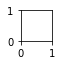

In [14]:
rbm_.plot_weights(min_max_scale = True)

#### Saving the model with joblib

In [13]:
#import joblib

# save the classifier
#joblib.dump(rbm_, filename="./saved_models/rbm.pkl")    

# load it again
#rbm2 = joblib.load("./saved_models/rbm.pkl")

In [14]:
#plt.imshow(rbm2.W[:,3].reshape(28,28), cmap="gray")

## Using the model as a feature generation machine

In [15]:
import sklearn
from sklearn import ensemble
from sklearn import linear_model
import pandas
import numpy as np

In [16]:
X_ = pandas.read_csv("../Datasets/MNIST/train_mnist.csv")
Y = X_["label"].values
X = X_[X_.columns[1:]].values

X = np.array(([14,14,14,14,14],[0,0,0,0,0]))
Y = np.array(([1,0]))

In [17]:
model = sklearn.linear_model.Perceptron(max_iter = 50)
model.fit(X,Y)

Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      max_iter=50, n_iter=None, n_jobs=1, penalty=None, random_state=0,
      shuffle=True, tol=None, verbose=0, warm_start=False)

In [22]:
test_predict = np.array(([14,0,0,0,0],[0,0,0,0,0]))
print(model.predict(test_predict))
print("train accuracy:",np.mean(Y==model.predict(X)))

[1 0]
train accuracy: 1.0


#### Learn perceptron on top of Features given by the RBM

In [23]:
X_features_rbm = rbm_.propup(X)

In [24]:
model = sklearn.linear_model.Perceptron(max_iter = 50)
model.fit(X_features_rbm ,Y)

Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      max_iter=50, n_iter=None, n_jobs=1, penalty=None, random_state=0,
      shuffle=True, tol=None, verbose=0, warm_start=False)

In [25]:
print("train accuracy:",np.mean(Y==model.predict(X_features_rbm )))

train accuracy: 1.0


## Sampling from an RBM

#### Sampling from a hidden state configuration

In [26]:
np.random.seed(123)
h_hat = np.array([np.random.randint(2) for i in range(rbm_.hidden_dim)])

In [27]:
x_hat, x_hat_p = rbm_.sample_visible_from_hidden(h_hat, n_gibbs=2000)
plt.imshow(x_hat.reshape(28,28))
plt.imshow(x_hat_p.reshape(28,28))

ValueError: cannot reshape array of size 5 into shape (28,28)

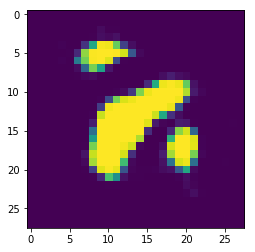

In [288]:
x_hat = sample_from_hidden(h_hat,rbm_, n_gibbs=2000)
plt.imshow(x_hat.reshape(28,28))

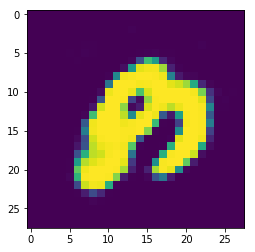

In [289]:
x_hat = sample_from_hidden(h_hat,rbm_, n_gibbs=2000)
plt.imshow(x_hat.reshape(28,28))

#### sampling starting form a visible vector

In [293]:
X[1,:].shape

(784,)

In [299]:
x = X[1,:]
x_hat, x_hat_p = rbm_.sample_visible_from_visible(x, n_gibbs=10)

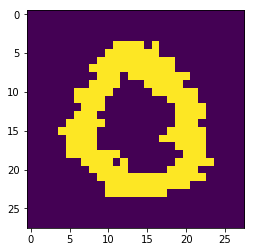

In [304]:
plt.imshow(x_hat.reshape(28,28))

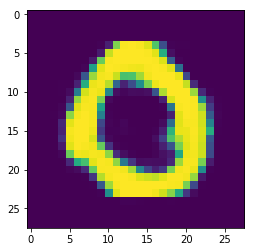

In [305]:
plt.imshow(x_hat_p.reshape(28,28))

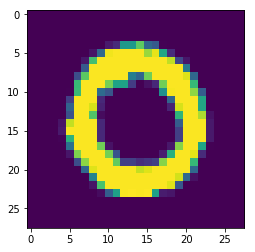

In [303]:
plt.imshow(x.reshape(28,28))